# K-Means Clustering

K-Means clustring of dataset and displaying the classified resutls. Developed by Pratham Shah

### Imports

In [313]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

### Establishing the dataset

In [314]:
orignal = pd.read_csv("Clustering_Data.csv")
data = orignal.copy()

In [315]:
titles = list(data)
data.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


### Defining the functions for clustering

In [316]:
def z(X):
    #Z score normalisation algorithm. Returns z score normalised dataset, means and std. deviations of the features.
    # find the mean of each n columns
    means     = np.mean(X, axis=0)                 # mean will have length n
    # find the standard deviation of each n columns
    stdevs  = np.std(X, axis=0)+0.00001                 # sigma will have length n. +0.00001 to prevent divide by 0 error.
    X_norm = (X - means) / stdevs    

    return X_norm, means, stdevs

data, means, stddevs = z(data)

def return_closest_centroid (point, centroids): #returns the centroid that is closest to the given datapoint and sum of euclidean distances
    distances = []
    for index, item in enumerate(centroids):
        distances.append(np.linalg.norm(point - item)) #distances of point from various centroids
    return (centroids[distances.index(min(distances))], sum(distances)) #returns nearest centroid and sum of euclidean distances

def map_points(centroids, points): #returns {point, centroid that is closest to that point}
    mapping = []
    for index, point in enumerate(points):
        mapping.append({"point" : point, "centroid" : return_closest_centroid(point, centroids)[0]}) #{point: that point, centroid: the closest centroid}
    return mapping

def get_means_from_clusters(pointmap, corrcentroids):
    means = []
    for centroid in corrcentroids:
        means.append(np.mean(np.array([point["point"] for point in pointmap if (point["centroid"] == centroid).all()]), axis=0))
    return means #list of mean points for all items in particular clusters

def graphing (points, centroids):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    ax.grid()
    for centroid in centroids:
        values = [point["point"] for point in points if (point['centroid'] == centroid).all()]   
        xs = list(map(lambda x:x[0], values))
        ys = list(map(lambda x:x[1], values))
        zs = list(map(lambda x:x[2], values))
        ax.scatter(xs, ys, zs, s = 50)
    ax.set_title('3D Scatter Plot')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()
    
def calculate_cluster_variance(data):
    # Extract points and centroids from the input data
    points = np.array([d['point'] for d in data])
    centroids = np.array([d['centroid'] for d in data])

    # Find unique centroids and their indices
    unique_centroids, indices = np.unique(centroids, axis=0, return_inverse=True)

    # Calculate variances for each cluster
    variances = []
    for i in range(len(unique_centroids)):
        cluster_points = points[indices == i]
        if len(cluster_points) > 0:
            centroid = unique_centroids[i]
            squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
            variance = np.mean(squared_distances)
            variances.append(variance)
        else:
            variances.append(0)  # Handle empty clusters

    return variances

distances = []
def kmeans (points, init_centres, max_iterations):
    global distances
    pointmap = []
    centres = init_centres
    for i in range(0, max_iterations):
        pointmap = map_points(centres, points) # puts stuff into the pointmap
        centres = get_means_from_clusters(pointmap, centres)
        
        sumofpoints = 0
        for point in points:
            sumofpoints += return_closest_centroid(point, centres)[1]
        print(f"iter. {i} : sum of distance of all (normalised) points from their nearest centroid: {sumofpoints}")
        distances.append(sumofpoints)
        try:
            if(distances[-1] == distances[-2]):
                print("\n*** The model has reached maximum efficiency. There is no need to run more iterations now. ***\n")
                break
        except:
            continue
    pointmap = map_points(centres, points)
    print("CENTRES OF CLUSTERS:")
    print(centres)
    print(f"\n\nSum of variances with {len(init_centres)} clusters: {sum(calculate_cluster_variance(pointmap))}")
    #at this point, centres is storing the means and pointmap is storing {point, closest mean to that point}
    graphing(pointmap, centres)

### Applying PCA to the dataset

It is observed that the first 3 columns account for the most variance in the data.

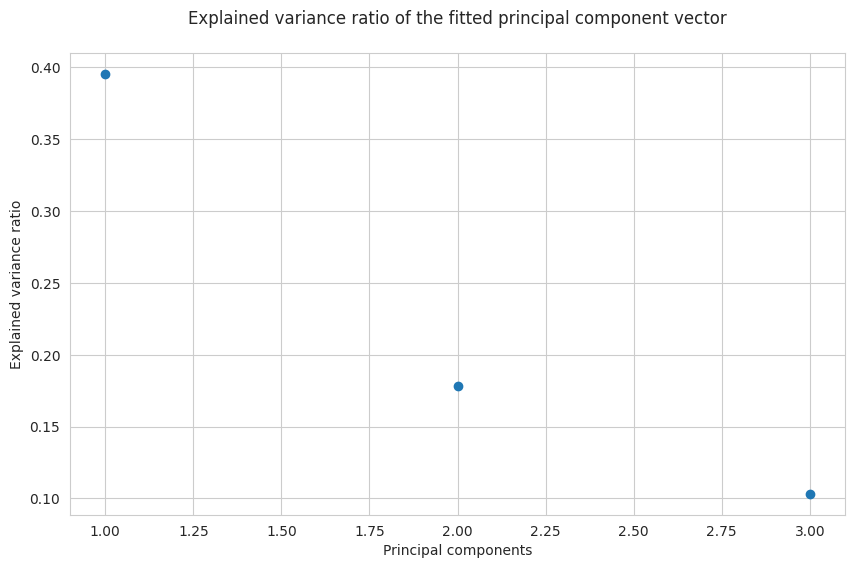

,0,1,2
0,-3.522903,1.453063,-0.164758
1,-2.528822,-0.329996,-2.026720
2,-2.784999,1.036871,0.983224
3,-3.922566,2.768142,-0.174904
4,-1.407510,0.867698,2.025773


In [317]:
pca = PCA(n_components=3)
data_pca = pca.fit(data)

plt.figure(figsize=(10,6))
plt.scatter([i+1 for i in range(len(data_pca.explained_variance_ratio_))],data_pca.explained_variance_ratio_)
plt.grid()
plt.title("Explained variance ratio of the fitted principal component vector\n")
plt.xlabel("Principal components")
plt.ylabel("Explained variance ratio")
plt.show()

data_trans = pca.transform(data)
data_trans = pd.DataFrame(data=data_trans)
data = data_trans
data.head()

### Running the model

Variations with K = 4, 3 and 2:\
9.739929323519677, 8.071914406510198, 10.304298718130566\
K=3 achieves least variance, and thus we can consider it to be the ideal number of clusters.

iter. 0 : sum of distance of all (normalised) points from their nearest centroid: 1857.976656551534
iter. 1 : sum of distance of all (normalised) points from their nearest centroid: 1851.2293781252383
iter. 2 : sum of distance of all (normalised) points from their nearest centroid: 1911.567842355208
iter. 3 : sum of distance of all (normalised) points from their nearest centroid: 1942.7529846066789
iter. 4 : sum of distance of all (normalised) points from their nearest centroid: 1944.3111882343107
iter. 5 : sum of distance of all (normalised) points from their nearest centroid: 1944.3111882343107

*** The model has reached maximum efficiency. There is no need to run more iterations now. ***

CENTRES OF CLUSTERS:
[array([-2.54882967e+00,  9.36581618e-01,  1.63130308e-03]), array([ 0.1217352 , -1.75034981,  0.12831262]), array([ 3.05859554,  1.208273  , -0.17751196])]


Sum of variances with 3 clusters: 8.071914406510198


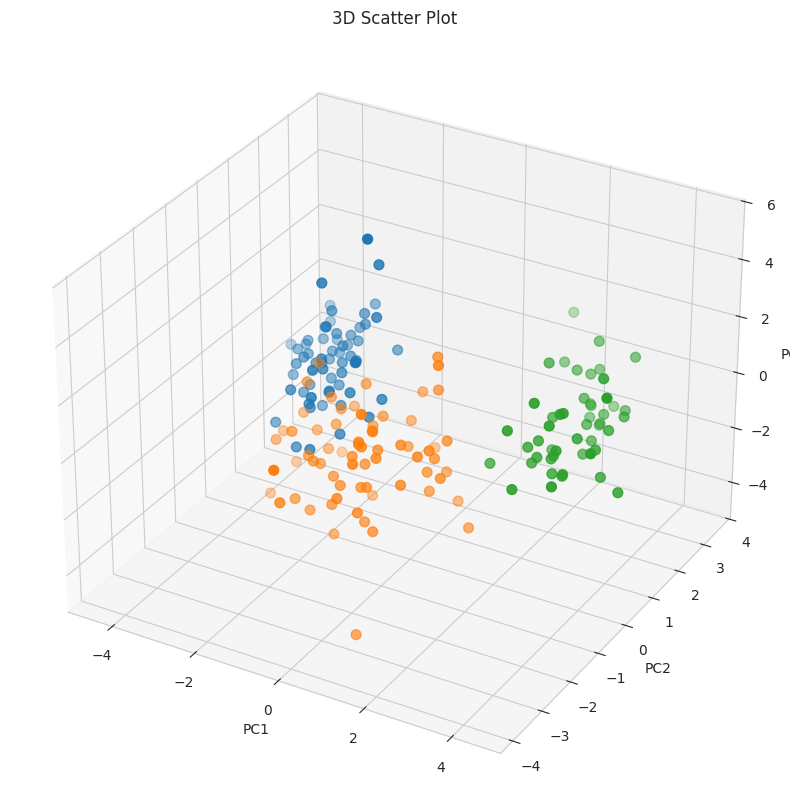

In [318]:
kmeans(data.values, data.values[0:3], 50)